In [2]:
import pandas
import numpy
import csv
import os
import warnings
from tqdm import tqdm
from functions import *

from pytest import skip

df_user_info = pandas.read_csv('user_list_more_than_20.csv')
df_anime_x = pandas.read_csv('top_and_bottom_anime.csv')
df_anime_y = pandas.read_csv('anime_matrix_true.csv')

#create main split for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_anime_x, df_anime_y, test_size=0.2, random_state=42)

#create cross training split for building the models
X_cross_train, X_cross_test, y_cross_train, y_cross_test = train_test_split(X_train, y_train, test_size=0.2, random_state=1080)

In [4]:
X_test.shape

(112, 8)

In [3]:
#Same spits are performed again to create df_true to check accuracy 
#create main split for training and testing
from sklearn.model_selection import train_test_split
A_train, A_test, b_train, b_test = train_test_split(df_anime_y, df_anime_y, test_size=0.2, random_state=42)

#create cross training split for building the models
A_cross_train, A_cross_test, b_cross_train, b_cross_test = train_test_split(A_train, b_train, test_size=0.2, random_state=1080)

df_true = A_cross_test.copy()

In [3]:
#knn
#create user list
watch_values = y_cross_train.values
users = y_cross_train.columns[1:]

#get rows of anime in the test list
rows = X_cross_test['Id'].copy()

#create watch list based on df_anime_y
users_watched = []
for i in (range(len(users))):
    watched = []
    for j in range(len(watch_values)):
        if(watch_values[j][i+1]):
            watched.append(str(watch_values[j][0]))
    users_watched.append(watched)

#compute all distances and dump to file
#for Create_soup_selection choose all, or choose between studio, source, genre, va
test = X_cross_test.copy()
train = X_cross_train.copy()

all_distances = []
for j in (range(len(test))):
    bag1 = Create_soup_selection(test.iloc[j],studio=False,source=True,genre=True,va=True).split()
    distances = []
    for i in range(len(train)):
        bag2 = Create_soup_selection(train.iloc[i],studio=False,source=True,genre=True,va=True).split()
        distances.append((train.iloc[i]['Id'].replace('\'',''),Jaccard(list(bag1),list(bag2))))
    Sort_Tuple(distances)
    all_distances.append(distances)

#KNN implementation

#make empty prediction matrix
#add anime Id column from 'rows'
#for every user
#   for each list of distances
#       find value of sum and divide by k
#       if sum / k is >= 0.5 predict 1, else predict 0
#   append to list of predictions

for knn in tqdm(range(11,12)):
    neighbors = knn
    prediction_result = []
    for j in (range(len(users))):
        col = users[j]
        watched = users_watched[j]
        predictions = []
        for k in range(len(all_distances)):
            distances = all_distances[k]
            #compute the sum
            neigh = []
            for i in range(neighbors):
                neigh.append(distances[i][0])
            value = len(list(set(neigh).intersection(watched)))
            if (value / neighbors) > 0.5:
                predictions.append(1)
            else:
                predictions.append(0)
        prediction_result.append(predictions)

    #create df_predictions
    warnings.simplefilter(action='ignore', category=pandas.errors.PerformanceWarning)
    knn_predictions = pandas.DataFrame()
    knn_predictions['Id'] = rows
    for i in range(len(users)):
        col = users[i]
        knn_predictions[col] = prediction_result[i]

100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


In [4]:
#items2items
#create list of anime in test set 
test_anime = []
for i in range(len(X_cross_test)):
    test_anime.append(X_cross_test.iloc[i]['Id'].replace('\'',''))

#create user list
watch_values = y_cross_train.values
users = y_cross_train.columns[1:]

#create watch list based on df_anime_y
users_watched = []
for i in tqdm(range(len(users))):
    watched = []
    for j in range(len(watch_values)):
        if(watch_values[j][i+1]):
            watched.append(str(watch_values[j][0]))
    users_watched.append(watched)

#read each user's watch list and creates a bag of words of all anime they watched
user_bag_result = []
length = len(users)

for j in tqdm(range(length)):
    # user = df_mini_watch_list.loc[j]['user']
    watched = users_watched[j]
    bag = ''
    for k in range(len(watched)):
        if watched[k] not in test_anime:
            try:
                temp = '\'' + str(watched[k]) + '\''
                index = df_anime_x.loc[df_anime_x['Id'] == temp].index[0]
                bag += ' ' + Create_soup_selection(df_anime_x.loc[index],studio=False,source=True,genre=True,va=True)
            except:
                pass
    user_bag_result.append([users[j],bag])

#creates a bag of words for each anime
anime_bag_result = []
for i in tqdm(range(len(X_cross_test))):
    anime = X_cross_test.iloc[i]['Id'].replace('\'','')
    bag = Create_soup_selection(X_cross_test.iloc[i],studio=True,source=True,genre=True,va=False)
    anime_bag_result.append([anime,bag])

df_user_bag = pandas.DataFrame(user_bag_result, columns=['user','bag of words'])
df_anime_bag = pandas.DataFrame(anime_bag_result, columns=['Id','bag of words'])

#Creates similarity matrix of all anime for all users
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# df_user_bag = pandas.read_csv('users_bag_of_words_drop_va.csv')
# df_anime_bag = pandas.read_csv('anime_bag_of_words_drop_va.csv')

count = CountVectorizer()
df_similarity = pandas.DataFrame()
df_similarity = df_true[['Id']].copy()
users = df_true.columns[1:]

for i in tqdm(range(len(users))):     #skip first item b/c that is anime id
    list_of_bag_of_words = [df_user_bag.loc[i]['bag of words']]

    count_matrix = count.fit_transform(df_anime_bag['bag of words'])
    try:
        count_matrix2 = count.transform(list_of_bag_of_words)
    except:
        #if user has an empty bag give them a matix of zeros
        count_matrix2 = count.transform(['a'])

    cosine_sim2 = cosine_similarity(count_matrix, count_matrix2)
    # sim_scores = list(enumerate(cosine_sim2))
    sim_scores = []
    for each in cosine_sim2:
        sim_scores.append(each[0])
    warnings.simplefilter(action='ignore', category=pandas.errors.PerformanceWarning)
    df_similarity[users[i]] = sim_scores

#Make predictions 
sim_val = df_similarity.values
similarity_interval = [0.42]

for i in tqdm(range(len(similarity_interval))):
    predictions = []
    for k in range(len(sim_val)):
        prediction_row = [int(sim_val[k][0])]
        for j in range(1,len(sim_val[k])):    #skip the first time b/c that is the anime Id
            if sim_val[k][j] >= similarity_interval[i]:
                prediction_row.append(1)
            else: 
                prediction_row.append(0)
        predictions.append(prediction_row)
    string_val = str(similarity_interval[i]).replace('.','')
    items2items_predictions = pandas.DataFrame(predictions, columns=df_true.columns)


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

df_anime = pandas.read_csv('top_and_bottom_anime.csv')
df_anime = df_anime.drop(columns='Id')
df_anime = df_anime.drop(columns='Rating')
df_anime = df_anime.drop(columns='Demographic')

new = pandas.DataFrame()
le = preprocessing.LabelEncoder()
for i in range(df_anime.shape[1]):
    temp = df_anime.iloc[:,i].values.tolist()
    temp = le.fit_transform(temp)
    new[df_anime.columns[i]] = temp

df_predictions = pandas.DataFrame()
df_predictions['Id'] = knn_predictions['Id'].copy()
df_anime_y = pandas.read_csv('anime_matrix_true.csv')
rows = df_anime_y[['Id']].copy()

#make adaboost predictions
columns = df_anime_y.columns
predictions = []

avg = []
for i in tqdm(range(1,len(columns))):   #skip first item b/c it's anime Id
    x = new
    y = df_anime_y[columns[i]]
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=42)
    
    #create cross training split for building the models
    X_cross_train, X_cross_test, y_cross_train, y_cross_test = train_test_split(x_train, y_train, test_size=0.2, random_state=1080)

    adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
    adaboost.fit(X_cross_train,y_cross_train)
    avg.append(adaboost.score(X_cross_test,y_cross_test))
    predictions.append(list(adaboost.predict(X_cross_test)))

import warnings
warnings.simplefilter(action='ignore', category=pandas.errors.PerformanceWarning)
for i in tqdm(range(1,len(columns))):
    df_predictions[columns[i]] = predictions[i-1]

adaboost_predictions = df_predictions.copy()

100%|██████████| 9028/9028 [00:07<00:00, 1279.27it/s]


In [59]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

df_anime = pandas.read_csv('top_and_bottom_anime.csv')
df_anime = df_anime.drop(columns='Id')
df_anime = df_anime.drop(columns='Rating')
df_anime = df_anime.drop(columns='Demographic')

new = pandas.DataFrame()
le = preprocessing.LabelEncoder()
for i in range(df_anime.shape[1]):
    temp = df_anime.iloc[:,i].values.tolist()
    temp = le.fit_transform(temp)
    new[df_anime.columns[i]] = temp

df_predictions = pandas.DataFrame()
df_predictions['Id'] = knn_predictions['Id'].copy()
df_anime_y = pandas.read_csv('anime_matrix_true.csv')
rows = df_anime_y[['Id']].copy()

#make adaboost predictions
columns = df_anime_y.columns
predictions = []

avg = []
for i in tqdm(range(1,len(columns))):   #skip first item b/c it's anime Id
    x = new
    y = df_anime_y[columns[i]]
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=42)
    
    #create cross training split for building the models
    X_cross_train, X_cross_test, y_cross_train, y_cross_test = train_test_split(x_train, y_train, test_size=0.2, random_state=1080)


    randomforest = tree.DecisionTreeClassifier()
    randomforest.fit(X_cross_train,y_cross_train)
    avg.append(randomforest.score(X_cross_test,y_cross_test))
    predictions.append(list(randomforest.predict(X_cross_test)))

import warnings
warnings.simplefilter(action='ignore', category=pandas.errors.PerformanceWarning)
for i in tqdm(range(1,len(columns))):
    df_predictions[columns[i]] = predictions[i-1]

randomforest_predictions = df_predictions.copy()

100%|██████████| 9028/9028 [00:06<00:00, 1340.84it/s]


In [11]:
import pickle

file = open('similarity_matrix.p', 'wb')
pickle.dump(knn_predictions,open('knn_predictions.p','wb'))
pickle.dump(items2items_predictions,open('items2items_predictions.p','wb'))
pickle.dump(adaboost_predictions,open('adaboost_predictions.p','wb'))
pickle.dump(randomforest_predictions,open('randomforest_predictions.p','wb'))

NameError: name 'randomforest_predictions' is not defined

In [4]:
import pickle

file = open('similarity_matrix.p', 'wb')
knn_predictions = pickle.load(open('knn_predictions.p','rb'))
items2items_predictions = pickle.load(open('items2items_predictions.p','rb'))
adaboost_predictions = pickle.load(open('adaboost_predictions.p','rb'))
randomforest_predictions = pickle.load(open('randomforest_predictions.p','rb'))

EOFError: Ran out of input

In [5]:
knn_val = knn_predictions.values
items2items_val = items2items_predictions.values
adaboost_val = adaboost_predictions.values
randomforest_val = randomforest_predictions.values
vote_threshold = 2

row = len(knn_val)
col = len(knn_val[0])
predictions_list = []

for i in range(row):
    prediction = [knn_val[i][0]]
    for j in range(1,col):      #skip first item b/c that is anime Id
        vote = knn_val[i][j] + items2items_val[i][j]*0 + adaboost_val[i][j] + randomforest_val[i][j]*0
        if vote >= vote_threshold:
            prediction.append(1)
        else:
            prediction.append(0)
    predictions_list.append(prediction)

bagging_predctions = pandas.DataFrame(predictions_list,columns=df_true.columns)

NameError: name 'knn_predictions' is not defined

In [134]:
#caluclate accuracy
correct = 0
prediction_matrix = pandas.read_csv('items2items_sim_variable.csv')
pred_values = bagging_predctions.values
true_values = df_true.values
predict_watch = 0
true_watch = 0
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
positive = 0
null = 0

num_row = len(pred_values)
num_col = len(pred_values[0])
for i in tqdm(range(num_row)):
    for j in range(1,num_col):          #first item is the anime id, so we skip it
        if pred_values[i,j] == true_values[i,j]:
            correct += 1
        if pred_values[i,j] == 1:
            predict_watch += 1
            if true_values[i,j] == 1:
                true_pos += 1
                true_watch += 1
            else:
                false_pos += 1

        if pred_values[i,j] == 0:
            if true_values[i,j] == 0:
                true_neg += 1
            else:
                false_neg += 1
                true_watch += 1
        
        if true_values[i,j] == 1:
            positive += 1

        if 0 == true_values[i,j]:
            null += 1
        

#subtracting 1 from column length b/c the first item is the anime id
percent = (correct / ((num_row) * (num_col-1)))
total = (num_row) * (num_col-1)
print(f'Total predictions: {total}')
print(f'Total Positives: {positive}')
print(f'Correct predictions: {correct}')

print(f'Predicted watch: {predict_watch}')
print(f'True watched: {true_watch}')
print(f'True positive: {true_pos}')
print(f'True negative: {true_neg}')
print(f'False negative: {false_neg}')
print(f'Null Error Rate: {(null / total)*100: .2f}')
print(f'False positive: {false_pos}')
print(f'Percent correct: {percent * 100: .2f}%')
print(f'Precision: {(true_pos / (true_pos + false_pos)): .2f}')
print(f'Recall: {(true_pos / (true_pos + false_neg)): .2f}')

100%|██████████| 89/89 [00:00<00:00, 142.73it/s]

Total predictions: 803492
Total Positives: 182661
Correct predictions: 653307
Predicted watch: 75520
True watched: 182661
True positive: 53998
True negative: 599309
False negative: 128663
Null Error Rate:  77.27
False positive: 21522
Percent correct:  81.31%
Precision:  0.72
Recall:  0.30


C:\Users\Tenkawa PC\AppData\Local\Temp\ipykernel_14148\678633288.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax= plt.subplot()


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

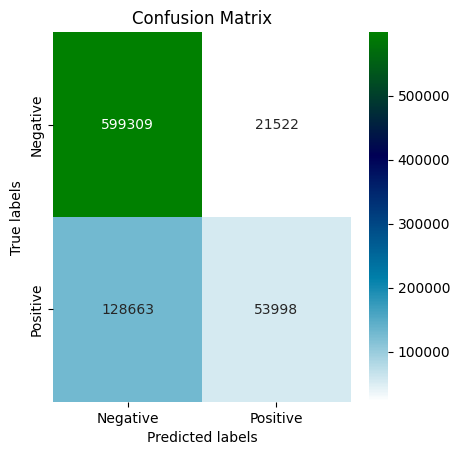

In [135]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  

#have to convert true_values and pred_values from matrix to list
y_true = []
y_pred = []
for i in range(len(true_values)):
    y_true += list(true_values[i][1:])
    y_pred += list(pred_values[i][1:])

cm = confusion_matrix(y_true,y_pred)
plt.matshow(cm)

   

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='ocean_r');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

In [121]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print(f'Accuray: {accuracy_score(y_true, y_pred):.2f}')
print(f'Precision: {precision_score(y_true, y_pred):.2f}')
print(f'Recall: {recall_score(y_true, y_pred):.2f}')
print(f'F1 score: {f1_score(y_true, y_pred):.2f}')

Accuray: 0.81
Precision: 0.67
Recall: 0.35
F1 score: 0.46
